In [1]:
import random
import array
from deap import base
from deap import tools
from deap import creator
import sympy
from sympy.solvers import solve
from sympy import Symbol
from sympy import Eq
import networkx
from sympy import exp
import matplotlib.pyplot as plt
from mpmath import mp
import math
from deap import benchmarks
import numpy
from itertools import chain
##Define constants
## number of individuals in the population
NP = 20
##coefficients from the datasheet of the PV panel
IscTempcoeff = 0.059
VocTempcoeff = -0.32
PeakPowTempcoeff = - 0.43
Voc = 45.79
Vmp = 36.38
Isc = 8.99
Imp = 8.52
q = 1.620217646 *(10**(-19)) 
k = 1.32806503*(10**(-23))
Scell = 72
T = 25
Vt = (Scell * k*T)/q

##amount of generations
max =10
f= open("solinent.txt","w+")
##lower and upper bounds of the variables to solve
Xih = [2, 1, 3000, 10**(-9), Isc]
Xil = [1, 0.1, 50, 10**(-14), 0.000]


Start to define the mutation,crossover, penalty and evaluation function from the paper

Mutation:
![title](Capture4.png)
![title](Capture5.png)

In [2]:
#mutation function
def mutateDE(mutant, a, b, c, f):
    size = len(mutant)
    for k in range(size):
        mutant[k] = a[k] + f * (b[k] - c[k])
    return mutant

Crossover and penalty function:
![title](Capture3.png)

In [3]:
#crossover based on binomial
def cxBinomial(x, mutant, cr):
    size = len(x)
    index = random.randrange(size)
    for i in range(size):
        if ((i == index) or (random.random() <= cr)):
            x[i] = mutant[i]
    return x

def cxExponential(x, y, cr):
    size = len(x)
    index = random.randrange(size)
    # Loop on the indices index -> end, then on 0 -> index
    for i in chain(range(index, size), range(0, index)):
        x[i] = y[i]
        if random.random() < cr:
            break
    return x

#Penalty function to ensure the parameters remain in acceptable range
def cxPenalty(x):
    z = random.uniform(0, 1)
   
    if (x[0] > Xih[0]):
        x[0] = x[0] - (z * (Xih[0] - Xil[0]))
    if (x[1] > Xih[1]):
        x[1] = x[1] - (z * (Xih[1] - Xil[1]))
    if (x[2] > Xih[2]):
        x[2] = x[2] - (z * (Xih[2] - Xil[2]))
    if (x[3] > Xih[3]):
        x[3] = x[3] - (z * (Xih[3] - Xil[3]))
    if (x[4] > Xih[4]):
        x[4] = x[4] - (z * (Xih[4] - Xil[4]))
        
        
    if (x[0] < Xil[0]):
        x[0] = x[0] + (z * (Xih[0] - Xil[0]))
    if (x[1] < Xil[1]): 
        x[1] = x[1] + (z * (Xih[1] - Xil[1]))
    if (x[2] < Xil[2]):
        x[2] = x[2] + (z * (Xih[2] - Xil[2]))
    if (x[3] < Xil[3]):
        x[3] = x[3] + (z * (Xih[3] - Xil[3]))
    if (x[4] < Xil[4]):
        x[4] = x[4] + (z * (Xih[4] - Xil[4]))
        
        
    return x


In [4]:
X = [-3, 1, 3000, 10**(-9), Isc]
print(cxPenalty(X))

[-2.0404636010669974, 1, 3000, 1e-09, 8.99]


In [5]:
# Imp = 3.15
# Vmp = 17.4

Objective function:

![title](Capture.png)


Parameter definitions:

![title](Capture2.png)

In [6]:

#evaluation and selection function
def eval(a, Rs, Rp, Io):
    r = (1 / (a * Vt))
#     print(Vt)
#     print(r)
    Gp = (1 / Rp)
#     print(Gp)
    preex = (r*(Vmp + (Imp * Rs)))
#     print(preex)
    expo = mp.exp(preex)
#     print(expo)
    Jnum1 = (Io) * (r) * expo 
    Jnum = Jnum1 - (Gp)
    #print(Jnum)
    Jden = 1 + ((Rs)*(Jnum1)) + (Gp * Rs)
#     print(Jden)
    J = -(Jnum / Jden) + (Imp/Vmp)
#     if(-(Jnum / Jden) > -1):
#         print(-(Jnum / Jden))
#     print("J=",J)
    return (abs(J))



In [7]:
# print(eval(1.37,0.3,2.34,10**(-12)))
# print(10**(-12))

Register the defined functions above to the deap framework and setup the statistics to keep track of the population progression

In [8]:
    generation = 0
    # DEAP framework definition
    creator.create("Fitnessmin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", array.array, typecode='d', fitness=creator.Fitnessmin)
    toolbox = base.Toolbox()
    toolbox.register("attr_a", random.uniform, 1, 2)
    toolbox.register("attr_rs", random.uniform, 0.1, 1)
    toolbox.register("attr_rp", random.uniform, 50, 3000)
    toolbox.register("attr_io", random.uniform, 10**(-14),10**(-9))
    toolbox.register("attr_ipv", random.uniform, 0.1, Isc)
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.attr_a, toolbox.attr_rs, toolbox.attr_rp, toolbox.attr_io, toolbox.attr_ipv), 1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mutate", mutateDE, f=0.4)
    toolbox.register("select", tools.selRandom, k=3)
    toolbox.register("mate", cxBinomial, cr=0.4)
    toolbox.register("evaluate", eval)
      
    # generate population
    pop = toolbox.population(n=NP)
    ## Hall of fame to save the best individual
    hof = tools.HallOfFame(1)
    
    #Initialize stats
    stats = tools.Statistics(lambda agent: agent.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"
    #store statistics for initial population
    for agent in pop:
        fit = toolbox.evaluate(agent[0], agent[1], agent[2], agent[3])
        agent.fitness.values = fit,
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(pop), **record)
    print(logbook.stream)
    printy = 0
    f.write("Initial population:")
    f.write("\n")
    while(printy < len(pop)):
        f.write("Individual index = " + str(printy))
        f.write("\n")
        f.write(str(pop[printy]))
        f.write("\n")
        print("Individual index = ",printy)
        print(pop[printy])
        if (pop[printy][0] > Xih[0] or pop[printy][1] > Xih[1] or pop[printy][2] > Xih[2] or pop[printy][3] > Xih[3] or pop[printy][4] > Xih[4]):
            f.write("Individual outside of allowed range!")
            f.write("\n")
            f.write(str(pop[printy]))
            f.write("\n")
            print("Individual outside of allowed range!")
            print(pop[printy])
        if (pop[printy][0] < Xil[0] or pop[printy][1] < Xil[1] or pop[printy][2] < Xil[2] or pop[printy][3] < Xil[3] or pop[printy][4] < Xil[4]):
            f.write("Individual outside of allowed range!")
            f.write("\n")
            f.write(str(pop[printy]))
            f.write("\n")
            print("Individual outside of allowed range!")
            print(pop[printy])
            
        printy = printy + 1



gen	evals	std             	min              	avg             	max             
0  	20   	2.32350291340478	0.847224652642308	3.22502264765347	8.88991745245427
Individual index =  0
Individual('d', [1.6712500256104832, 0.3641885408288493, 2882.8333992602115, 2.269852304570672e-10, 0.5594343985629294])
Individual index =  1
Individual('d', [1.4873432754487765, 0.6546295280494581, 2548.570326977382, 6.406584734069417e-10, 7.6576334696288475])
Individual index =  2
Individual('d', [1.65691902456185, 0.6487816769746327, 2952.2291989342075, 1.753361656189424e-10, 8.55211792320967])
Individual index =  3
Individual('d', [1.3460199726844615, 0.4802433608281287, 2719.2003534973546, 5.542459874454987e-10, 2.025164775592238])
Individual index =  4
Individual('d', [1.8784863456678897, 0.36390105852451216, 281.92144131722114, 7.128036874103313e-10, 6.826172210306044])
Individual index =  5
Individual('d', [1.6810120371295163, 0.3506881256404968, 2945.7493146980637, 6.649231081279969e-10, 5.317544145

Perform the differential evolution algorithm searching for the global minimum

In [9]:
f.write("\n")
f.write("--------------------------------------------------------------------------------------------------")
f.write("\n")
f.write("Move onto producing offspring:")
f.write("\n")
f.write("--------------------------------------------------------------------------------------------------")
f.write("\n")
while (generation < max):
        f.write("\n")
        f.write("--------------------------------------------------------------------------------------------------")
        f.write("\n")
        f.write("Generation = :" + str(generation + 1))
        f.write("\n")
        f.write("--------------------------------------------------------------------------------------------------")
        f.write("\n")
        for i, agent in enumerate(pop):
            # Mutation
            f.write("\n")
            f.write("--------------------------------------------------------------------------------------------------")
            f.write("\n")
            f.write("Individual = :" + str(i + 1))
            f.write("\n")
            f.write("--------------------------------------------------------------------------------------------------")
            f.write("\n")
            f.write("Selecting three individual:")
            f.write("\n")
            print("Selecting three individual:")
            a, b, c = [toolbox.clone(ind) for ind in toolbox.select(pop)]
            f.write("Indiviual 1 = " + str(a))
            f.write("\n")
            f.write("Indiviual 2 = " + str(b))
            f.write("\n")
            f.write("Indiviual 3 = " + str(c))
            f.write("\n")
            print("Indiviual 1 = ",a)
            print("Indiviual 2 = ",b)
            print("Indiviual 3 = ",c)
            f.write("Producing mutant:")
            f.write("\n")
            print("Producing mutant:")
            mutant1 = toolbox.clone(agent)
            f.write("clone1 = " +str(mutant1))
            f.write("\n")
            print("clone1 = ",mutant1)
            mutant = toolbox.clone(agent)
            print("clone2 = ",mutant)
            f.write("clone2 = " +str(mutant))
            f.write("\n")
            mutant = toolbox.mutate(mutant, a, b, c)
            print("mutant = ",mutant)
            f.write("mutant = " +str(mutant))
            f.write("\n")
            # crossover
            f.write("Applying crossover:")
            f.write("\n")
            print("Applying crossover:")
            trialvec = toolbox.mate(mutant1, mutant)
            f.write("trial vector = " + str(trialvec))
            f.write("\n")
            print("trial vector = ",trialvec)
            trialvec = cxPenalty(trialvec)
            f.write("trial vector post penalty = " + str(trialvec))
            f.write("\n")
            print("trial vector post penalty = ",trialvec)
            if (trialvec[0] > Xih[0] or trialvec[1] > Xih[1] or trialvec[2] > Xih[2] or trialvec[3] > Xih[3] or trialvec[4] > Xih[4]):
                f.write("Penalty function correction failed!")
                f.write("\n")
                f.write(str(trialvec))
                f.write("\n")
                print("Penalty function correction failed!")
                print(trialvec)
            if (trialvec[0] < Xil[0] or trialvec[1] < Xil[1] or trialvec[2] < Xil[2] or trialvec[3] < Xil[3] or trialvec[4] < Xil[4]):
                f.write("Penalty function correction failed!")
                f.write("\n")
                f.write(str(trialvec))
                f.write("\n")
                print("Penalty function correction failed!")
                print(trialvec)
            trialeval = (toolbox.evaluate(trialvec[0], trialvec[1], trialvec[2], trialvec[3]))
            curreval = (toolbox.evaluate(agent[0], agent[1], agent[2], agent[3]))
#             if((curreval < 0)and (trialeval<0) ):
#                 pop[i].fitness.values = math.inf, 
            pop[i].fitness.values = curreval, 
            if ((trialeval < curreval)):
                #selection -> trialvector is better than original vector
                pop[i] = trialvec
                pop[i].fitness.values = trialeval,
        hof.update(pop)
        record = stats.compile(pop)
        logbook.record(gen=generation, evals=len(pop), **record)
        print(logbook.stream)
        generation = generation + 1

f.write("DONE!")
f.close()        

Selecting three individual:
Indiviual 1 =  Individual('d', [1.8295713563294962, 0.864423291305507, 1164.212054857129, 6.957295262888897e-10, 3.927600797643914])
Indiviual 2 =  Individual('d', [1.8784863456678897, 0.36390105852451216, 281.92144131722114, 7.128036874103313e-10, 6.826172210306044])
Indiviual 3 =  Individual('d', [1.6712500256104832, 0.3641885408288493, 2882.8333992602115, 2.269852304570672e-10, 0.5594343985629294])
Producing mutant:
clone1 =  Individual('d', [1.6712500256104832, 0.3641885408288493, 2882.8333992602115, 2.269852304570672e-10, 0.5594343985629294])
clone2 =  Individual('d', [1.6712500256104832, 0.3641885408288493, 2882.8333992602115, 2.269852304570672e-10, 0.5594343985629294])
mutant =  Individual('d', [1.912465884352459, 0.8643082983837721, 123.84727167993287, 8.900569090701953e-10, 6.43429592234116])
Applying crossover:
trial vector =  Individual('d', [1.912465884352459, 0.8643082983837721, 123.84727167993287, 2.269852304570672e-10, 0.5594343985629294])
tri

clone1 =  Individual('d', [1.2573930442420456, 0.9596378307753155, 2548.570326977382, 6.406584734069417e-10, -0.13115389652290174])
clone2 =  Individual('d', [1.2573930442420456, 0.9596378307753155, 2548.570326977382, 6.406584734069417e-10, -0.13115389652290174])
mutant =  Individual('d', [1.536750468189497, 0.766013167110762, 1098.2659278017727, 8.506510996343137e-10, -0.812325784819641])
Applying crossover:
trial vector =  Individual('d', [1.2573930442420456, 0.766013167110762, 2548.570326977382, 6.406584734069417e-10, -0.812325784819641])
trial vector post penalty =  Individual('d', [1.2573930442420456, 0.766013167110762, 2548.570326977382, 6.406584734069417e-10, 3.7358964221445525])
Selecting three individual:
Indiviual 1 =  Individual('d', [1.3103294953232292, 0.864423291305507, 1164.212054857129, 8.35103412936359e-10, 0.3400089126024392])
Indiviual 2 =  Individual('d', [1.5404374459694372, 0.9206342300336173, 2888.4073056024786, 2.989149927060237e-10, 3.2999634651612353])
Indiviu

Selecting three individual:
Indiviual 1 =  Individual('d', [1.3103294953232292, 0.864423291305507, 1164.212054857129, 8.35103412936359e-10, 0.3400089126024392])
Indiviual 2 =  Individual('d', [1.5568891389020596, 0.8049006618951577, 1952.1592129664268, 6.464260066809227e-10, 0.17618995938917548])
Indiviual 3 =  Individual('d', [1.3049147320477728, 0.7950849072886398, 2051.9575449367367, 8.719925331215461e-10, 0.921687129756965])
Producing mutant:
clone1 =  Individual('d', [1.3049147320477728, 0.7950849072886398, 2051.9575449367367, 8.719925331215461e-10, 0.921687129756965])
clone2 =  Individual('d', [1.3049147320477728, 0.7950849072886398, 2051.9575449367367, 8.719925331215461e-10, 0.921687129756965])
mutant =  Individual('d', [1.4111192580649439, 0.8683495931481142, 1124.292722069005, 7.448768023601096e-10, 0.04181004445532338])
Applying crossover:
trial vector =  Individual('d', [1.4111192580649439, 0.8683495931481142, 2051.9575449367367, 7.448768023601096e-10, 0.04181004445532338])


In [21]:

##extract best individual from the hall of fame
bestid = hof[0]
fit = hof[0].fitness
print("fitness =",fit)
##extract parameters from individual
a = ((bestid[0]))
Rs = ((bestid[1]))
Rp = ((bestid[2]))
io = ((bestid[3]))
print("io =",io)
print("Rs =",Rs)
print("Rp = ",Rp)
print("a =",a)
#print("evaluation function =",toolbox.evaluate(a, Rs, Rp, io))
r = (1.0 / (a * Vt))
print("r =",r)
#Solve to ensure that Imp is retrieved when Vmp is provided
print("solving start:")
exp1 = (Vmp +(Imp*Rs))*r
s1= mp.exp(exp1) -1
s1a = io*s1
s2 = (Vmp + (Imp*Rs))/(Rp)
s3 = Isc - s1a - s2
t =[]
v = []
p = []
print("Imp =",s3)
for V in range(45):
    v.append(V)
    I = sympy.Symbol('I')
    eqn = Eq(Isc-io*(((exp(r*(V + (I * Rs))))) - 1)-((V+(I*Rs))/Rp ))
    curr = solve(eqn,I,rational=False,real=True)
    t.append(curr)
    print((curr))
    p.append(V * curr)
    print(v[V])
    print(t[V])
    #print(p[V])
    
    

fitness = (mpf('0.78496308980049467'),)
io = 5.646695424746295e-10
Rs = 0.9812024162864286
Rp =  1612.364801725004
a = 1.4384851134640155
r = 4.711683825102492
solving start:
Imp = -2.0001936783754e+82
[5.08110796770052]
0
[5.08110796770052]
[4.06195026547539]
1
[4.06195026547539]
[3.04279256325026]
2
[3.04279256325026]
[2.02363486102513]
3
[2.02363486102513]
[1.00447715879818]
4
[1.00447715879818]
[-0.0146805434251291]
5
[-0.0146805434251291]
[-1.03383824565026]
6
[-1.03383824565026]
[-2.05299594787357]
7
[-2.05299594787357]
[-3.07215365010052]
8
[-3.07215365010052]
[-4.09131135232383]
9
[-4.09131135232383]
[-5.11046905455078]
10
[-5.11046905455078]
[-6.12962675677227]
11
[-6.12962675677227]
[-7.14878445899922]
12
[-7.14878445899922]
[-8.16794216122435]
13
[-8.16794216122435]
[-9.18709986344766]
14
[-9.18709986344766]
[-10.2062575656728]
15
[-10.2062575656728]
[-11.2254152678997]
16
[-11.2254152678997]
[-12.2445729701194]
17
[-12.2445729701194]
[-13.2637306723482]
18
[-13.263730672348

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
[[5.08110796770052], [4.06195026547539], [3.04279256325026], [2.02363486102513], [1.00447715879818], [-0.0146805434251291], [-1.03383824565026], [-2.05299594787357], [-3.07215365010052], [-4.09131135232383], [-5.11046905455078], [-6.12962675677227], [-7.14878445899922], [-8.16794216122435], [-9.18709986344766], [-10.2062575656728], [-11.2254152678997], [-12.2445729701194], [-13.2637306723482], [-14.2828883745733], [-15.3020460767984], [-16.3212037790236], [-17.3403614812487], [-18.3595191834720], [-19.3786768856990], [-20.3978345879241], [-21.4169922901474], [-22.4361499923762], [-23.4553076945976], [-24.4744653968246], [-25.4936230990461], [-26.5127808012749], [-27.5319385034963], [-28.5510962057215], [-29.5702539079466], [-30.5894116101736], [-31.6085693123950], [-32.6277270146220], [-33.6468847168471], [-34.6660424

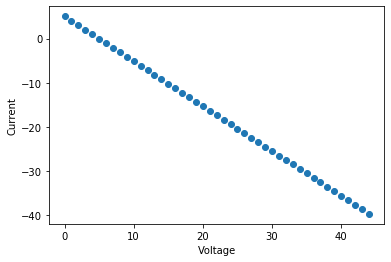

[[], [4.06195026547539], [3.04279256325026, 3.04279256325026], [2.02363486102513, 2.02363486102513, 2.02363486102513], [1.00447715879818, 1.00447715879818, 1.00447715879818, 1.00447715879818], [-0.0146805434251291, -0.0146805434251291, -0.0146805434251291, -0.0146805434251291, -0.0146805434251291], [-1.03383824565026, -1.03383824565026, -1.03383824565026, -1.03383824565026, -1.03383824565026, -1.03383824565026], [-2.05299594787357, -2.05299594787357, -2.05299594787357, -2.05299594787357, -2.05299594787357, -2.05299594787357, -2.05299594787357], [-3.07215365010052, -3.07215365010052, -3.07215365010052, -3.07215365010052, -3.07215365010052, -3.07215365010052, -3.07215365010052, -3.07215365010052], [-4.09131135232383, -4.09131135232383, -4.09131135232383, -4.09131135232383, -4.09131135232383, -4.09131135232383, -4.09131135232383, -4.09131135232383, -4.09131135232383], [-5.11046905455078, -5.11046905455078, -5.11046905455078, -5.11046905455078, -5.11046905455078, -5.11046905455078, -5.1104

ValueError: setting an array element with a sequence.

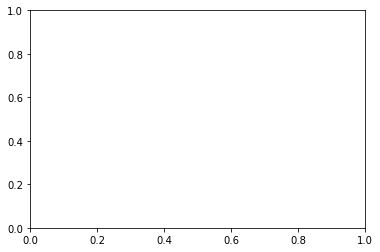

In [13]:
print(v)
print(t)
plt.plot(v,t,'o')
plt.ylabel("Current")
plt.xlabel("Voltage")
plt.savefig("IV.png")
plt.show()
print(p)
plt.plot(v,p,'o')

plt.ylabel("Power")
plt.xlabel("Voltage")
ply.savefig("PV.png")
plt.show()